/tmp/ipykernel_1246108/690635625.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20')(labels / max(unique_labels))


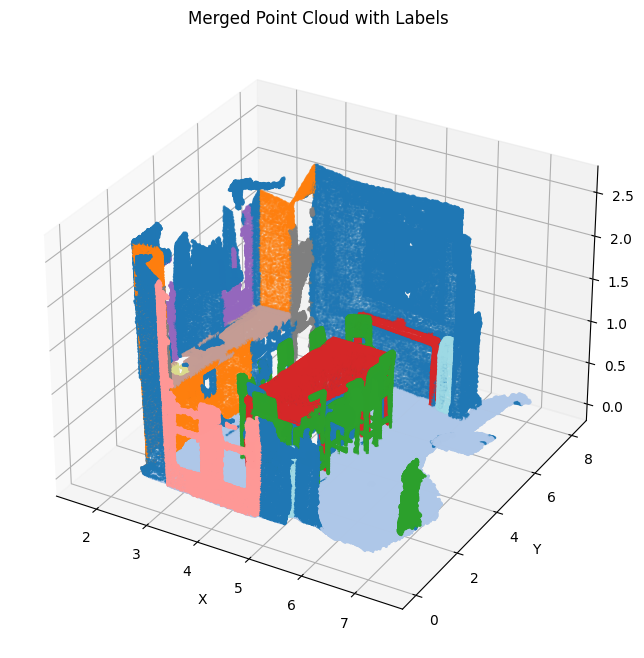

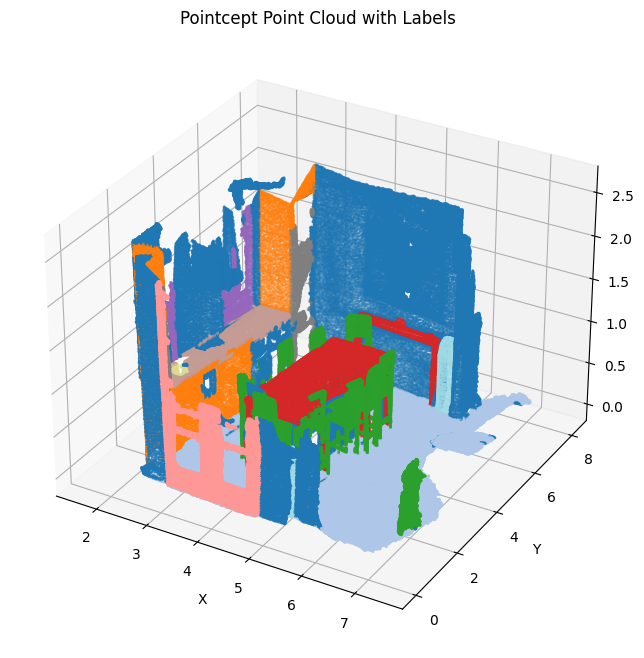

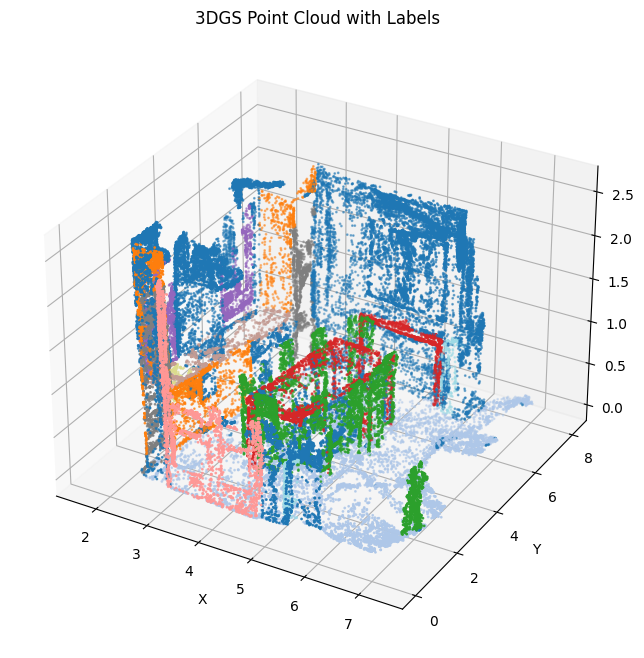

Inconsistent labels: 0 / 63142 (0.00%)


In [1]:
# visualize_point_cloud.ipynb

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData
import os
from sklearn.neighbors import NearestNeighbors

# PLY 파일 로드 함수
def load_ply(file_path, load_labels=False):
    plydata = PlyData.read(file_path)
    vertex = plydata['vertex']
    points = np.stack([vertex['x'], vertex['y'], vertex['z']], axis=-1)
    if load_labels and 'label' in vertex.data.dtype.names:
        labels = vertex['label']
        return points, labels
    return points

# Matplotlib으로 Point Cloud 시각화 함수
def visualize_point_cloud(points, labels=None, title="Point Cloud"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        # 라벨에 따라 색상 부여
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab20')(labels / max(unique_labels))
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
    else:
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', s=1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.show()

# 라벨 일관성 검증 함수
def check_label_consistency(points_pointcept, labels_pointcept, points_3dgs, labels_3dgs):
    # 3DGS 점과 가장 가까운 Pointcept 점의 라벨 비교
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(points_pointcept)
    distances, indices = nbrs.kneighbors(points_3dgs)
    
    # 3DGS 점의 라벨과 이웃 Pointcept 점의 라벨 비교
    inconsistent_count = 0
    inconsistent_indices = []
    for i in range(len(points_3dgs)):
        nearest_pointcept_labels = labels_pointcept[indices[i]]
        if labels_3dgs[i] not in nearest_pointcept_labels:
            inconsistent_count += 1
            inconsistent_indices.append(i)
    
    print(f"Inconsistent labels: {inconsistent_count} / {len(points_3dgs)} ({inconsistent_count / len(points_3dgs) * 100:.2f}%)")
    return inconsistent_indices

# PLY 파일 경로 설정
output_dir = "/home/knuvi/Desktop/song/gaussian-point-sampler/test/test_samples10"  # 실제 경로로 변경
exp = "pdistance_max00001"  # 실제 exp 이름으로 변경
merged_ply_path = os.path.join(output_dir, exp, f"{exp}.ply")
pointcept_ply_path = os.path.join(output_dir, exp, f"{exp}_pointcept.ply")
dgs_ply_path = os.path.join(output_dir, exp, f"{exp}_3dgs.ply")

# Merged Point Cloud 시각화 (라벨 포함)
points_merged, labels_merged = load_ply(merged_ply_path, load_labels=True)
visualize_point_cloud(points_merged, labels_merged, "Merged Point Cloud with Labels")

# Pointcept 점과 라벨 로드
points_pointcept = load_ply(pointcept_ply_path)
# Merged Point Cloud에서 Pointcept 점과 라벨 추출
num_pointcept_points = len(points_pointcept)
labels_pointcept = labels_merged[:num_pointcept_points]
visualize_point_cloud(points_pointcept, labels_pointcept, "Pointcept Point Cloud with Labels")

# 3DGS 점 시각화
points_3dgs, labels_3dgs = load_ply(dgs_ply_path, load_labels=True)
visualize_point_cloud(points_3dgs, labels_3dgs, "3DGS Point Cloud with Labels")

# 라벨 일관성 검증
if labels_3dgs is not None:
    inconsistent_indices = check_label_consistency(points_pointcept, labels_pointcept, points_3dgs, labels_3dgs)
    
    # 일관성 없는 점 시각화
    if inconsistent_indices:
        inconsistent_points = points_3dgs[inconsistent_indices]
        inconsistent_labels = labels_3dgs[inconsistent_indices]
        visualize_point_cloud(inconsistent_points, inconsistent_labels, "Inconsistent 3DGS Points")